# **구글 드라이브에 임베딩/텐서플로우 가져오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Transformer 구현을 위한 사전 import 과정

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Positional Encoding

(1, 50, 128)


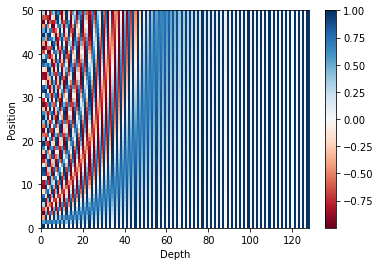

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Scaled-dot-product-attention 구현

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):

  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

  # 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


Multi-head Attention 구현

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

padding mask

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


Position-wise FFNN
인코더와 디코더 내부에서 사용할 코드.</br>
이게 PWFFNN</br>
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)</br>
outputs = tf.keras.layers.Dense(units=d_model)(outputs)</br>

# Encoder 구현

Encoder-layer 구현 및 Encoder 쌓기

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용 (인코더)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩과 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# **디코더 구현하기**

Decoder의 first sub-layer : self-attention, look-a-head mask

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크
  return tf.maximum(look_ahead_mask, padding_mask)

print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


Decoder의 second sub-layer : Encoder-Decoder Attention </br>
여기서, 인코더의 first - sub layer: Query = Key = Value</br>
디코더의 first - sub layer: Query = Key = Value</br>
디코더의 Second - sub layer: Query : decoder 행렬 / Key = Value : Encoder 행렬</br>

Decoder 구현.

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃과 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

디코더 쌓기

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩과 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# **Transformer 만들기**

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(1번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(2번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력

  # 디코더의 출력은 dec_outputs. 출력층으로 전달
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

transformer 하이퍼 파라미터 정하기 / 손실함수 정하기

(1, 9000, 512)
(1, 9000, 512)


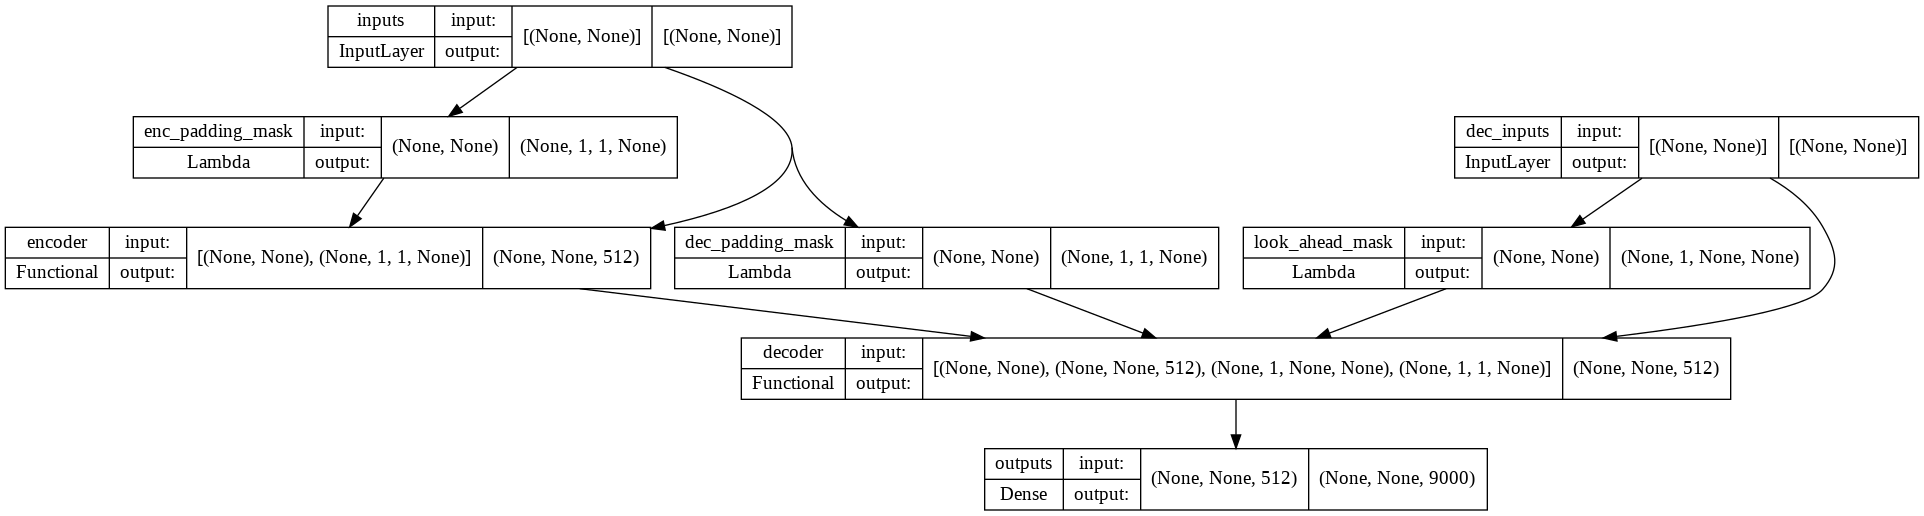

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 512,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)



In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  assert not np.any(np.isnan(mask))
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

학습률 정의하기

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)


    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

학습률 시각화

Text(0.5, 0, 'Train Step')

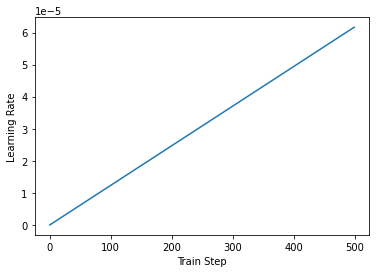

In [ ]:
sample_learning_rate = CustomSchedule(d_model=1024)

plt.plot(sample_learning_rate(tf.range(500, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# ** 입력 -> 출력물 결과보기** -> 위에서는 Transformer를 만들어본 것.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
import os
# 아래부분은 tpu 사용시에만 쓰길 바람
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

tf.keras.backend.clear_session()
#
# urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eda.csv') # , encoding='CP949'
train_data.head()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.125.160.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.125.160.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


,Q,A
0,UNKNOWN MESSAGE Please choose the Technical Su...,알 수 없는 메시지. 자세한 내용을 보려면 Visual C++ [도움말] 메뉴에서 ...
1,UNKNOWN MESSAGE Please choose the Technical Su...,알 수 없는 메시지. 자세한 내용을 보려면 Visual C++ [도움말] 메뉴에서 ...
2,UNKNOWN MESSAGE Please choose the Technical Su...,알 수 없는 메시지. 자세한 내용을 보려면 Visual C++ [도움말] 메뉴에서 ...
3,OF_MINE MESSAGE Please choose the Technical Sp...,알 수 없는 메시지. 자세한 내용을 보려면 Visual C++ [도움말] 메뉴에서 ...
4,GOD_IS MESSAGE Anyone_wishing choose the Techn...,알 수 없는 메시지. 자세한 내용을 보려면 Visual C++ [도움말] 메뉴에서 ...


In [ ]:
print('데이터 샘플의 개수 :', len(train_data))
print(train_data.isnull().sum())

데이터 샘플의 개수 : 11224
Q    0
A    0
dtype: int64


질문 데이터와 답변 데이터의 preprocessing

In [ ]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", str(sentence))     # 구두점에 대해서 띄어쓰기
    sentence = sentence.strip()
    questions.append(sentence)

answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", str(sentence))     # 구두점에 대해서 띄어쓰기
    sentence = sentence.strip()
    answers.append(sentence)

print(questions[:5])
print(answers[:5])

['UNKNOWN MESSAGE Please choose the Technical Support command on the Visual C++ Help menu ,  or open the Technical Support help file for more information', 'UNKNOWN MESSAGE Please choose the Technical Support command on the Multisensory C + + Help entrees ,  or open the Technical Support help file for more information', 'UNKNOWN MESSAGE Please choose the Technical Support command on the Visual Polyzene_® + + Help menu ,  or open the Technical Support help file for more info', 'OF_MINE MESSAGE Please choose the Technical Sponsors_Sunbelt_Software command on the Visual C + + Help menu ,  or open the Technical Support help file for more information', 'GOD_IS MESSAGE Anyone_wishing choose the Technical Support command on the Visual C + + Help menu ,  or open the Technical Support help file for more information']
['알 수 없는 메시지 .  자세한 내용을 보려면 Visual C++ [도움말] 메뉴에서 [기술 지원] 명령을 선택하거나 기술 지원 도움말 파일을 참조하세요 .', '알 수 없는 메시지 .  자세한 내용을 보려면 Visual C++ [도움말] 메뉴에서 [기술 지원] 명령을 선택하거나 기술 지원 도움말 파일을 참조하세요 .

단어 집함 생성 -> 서브워드 토크나이저에서 서브워드텍스트인코더 사용

In [ ]:
# 서브워드 텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8833]
종료 토큰 번호 : [8834]
단어 집합의 크기 : 8835


정수 encoding과 padding</br>
# 샘플 하나로 정수 인코딩, 디코딩 수행 (test)

In [ ]:
# 샘플 하나로 정수 인코딩, 디코딩 수행
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
sample_string = questions[20]

# encode() : 텍스트 시퀀스 -> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 -> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

임의의 질문 샘플을 정수 인코딩 : [615, 963, 8622, 171, 8622, 256, 424]
정수 인코딩 후의 문장 [615, 963, 8622, 171, 8622, 256, 424]
기존 문장: unexpected end-of-file found
615 ----> unexpected 
963 ----> end
8622 ----> -
171 ----> of
8622 ----> -
256 ----> file 
424 ----> found


In [ ]:
# 최대 길이를 90으로 정의
MAX_LENGTH = 90

def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11224, 90)
답변 데이터의 크기(shape) : (11224, 90)


임의의 0번 test

In [ ]:
from sklearn.model_selection import train_test_split
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])
for i in questions:
  if 0 not in i:
    print(i)
for j in answers:
  if 0 not in j:
    print(j)

# 길이가 90을 맞추기 위해 0이 패딩됨.

[8833 2389 8296 1419 1859   41  852  853  488  121   41  851 8644  966
 1884 1743   62   33  685   41  852  853 1643  256   27  487  700 8834
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[8833  332    6  192 2941   53 1564 1606 2918  851 8644 3351 2950  270
 2942  131  810 2825  270 1597 2036  810 1011 1045  260 2815    1 8834
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


인코더와 디코더 입력, 레이블 만들기

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))
print(dataset)
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

<TensorSliceDataset element_spec=({'inputs': TensorSpec(shape=(90,), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(89,), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(89,), dtype=tf.int32, name=None)})>
[8833  332    6  192 2941   53 1564 1606 2918  851 8644 3351 2950  270
 2942  131  810 2825  270 1597 2036  810 1011 1045  260 2815    1 8834
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[[8833  332    6  192 2941   53 1564 1606 2918  851 8644 3351 2950  270
  2942  131  810 2825  270 1597 2036  810 1011 1045  260 2815    1 8834
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   

# **Transformer 사용하기**
하이퍼 파라미터 값 순서대로: 256, 2, 8, 512로 설정</br>
학습률과 옵티마이저 정의

(1, 8835, 512)
(1, 8835, 512)
Epoch 1/500
176/176 [==============================] - 169s 387ms/step - loss: 0.9366 - accuracy: 0.0123
Epoch 2/500
176/176 [==============================] - 15s 86ms/step - loss: 0.6740 - accuracy: 0.0261
Epoch 3/500
176/176 [==============================] - 15s 86ms/step - loss: 0.5093 - accuracy: 0.0422
Epoch 4/500
176/176 [==============================] - 15s 86ms/step - loss: 0.3629 - accuracy: 0.0599
Epoch 5/500
176/176 [==============================] - 15s 85ms/step - loss: 0.2565 - accuracy: 0.0759
Epoch 6/500
176/176 [==============================] - 15s 85ms/step - loss: 0.1769 - accuracy: 0.0887
Epoch 7/500
176/176 [==============================] - 15s 85ms/step - loss: 0.1538 - accuracy: 0.0912
Epoch 8/500
176/176 [==============================] - 15s 86ms/step - loss: 0.1107 - accuracy: 0.0978
Epoch 9/500
176/176 [==============================] - 15s 86ms/step - loss: 0.0993 - accuracy: 0.1001
Epoch 10/500
176/176 [===================

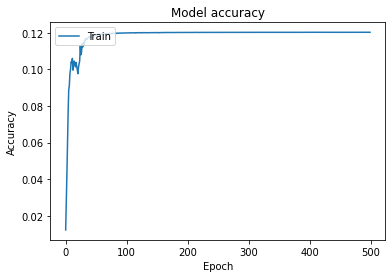

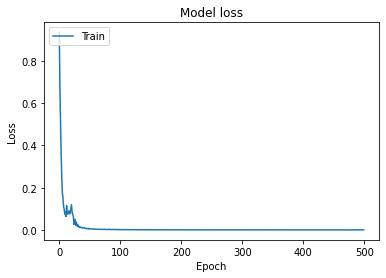

In [ ]:
# *중요* TPU 사용 전용이므로 GPU 사용시에는 이것을 사용하면 안됨

# 하이퍼파라미터
D_MODEL = 512
NUM_LAYERS = 6
NUM_HEADS = 8
DFF = 2048
DROPOUT = 0.1
EPOCHS = 500
# 총 500회 학습

# 1. 저장할 폴더와 형식을 선택
checkPoint_path = "saved_epoch/model_{epoch:04d}.ckpt" # 저장할 당시 epoch가 파일이름이 된다.
checkPoint_dir = os.path.dirname(checkPoint_path)

# 2. 콜백 변수를 생성
my_period = 1
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkPoint_path,
					save_weights_only=True, verbose=1, period=my_period) 

with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      dff=DFF,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)
  
  learning_rate = CustomSchedule(D_MODEL)

  optimizer = tf.keras.optimizers.Adam(
      learning_rate, beta_1=0.28, beta_2=0.98, epsilon=1e-9)

  def accuracy(y_true, y_pred):
    # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

  def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
  history = model.fit(dataset, epochs=EPOCHS,
                      verbose=1)
  
  print(history.history)

  # 6 훈련 과정 시각화 (정확도)
  plt.plot(history.history['accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  # 7 훈련 과정 시각화 (손실)
  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train'], loc='upper left')
  plt.show()


# **모델 불러오기 (안쓰는 코드)**

In [ ]:
with strategy.scope():
  # 1. 해당 폴더에서 가장 마지막 체크포인트 선택
  latest = tf.train.latest_checkpoint(checkPoint_dir)

  # 2. 해당체크포인트에 저장한 모델의 가중치 불러오기
  model.load_weights(latest)

ERROR:tensorflow:Couldn't match files for checkpoint /content/drive/MyDrive/Colab Notebooks/saved_epoch/model_0002.ckpt


ERROR:tensorflow:Couldn't match files for checkpoint /content/drive/MyDrive/Colab Notebooks/saved_epoch/model_0002.ckpt


AttributeError: ignored

# **GPU 사용시.**

In [ ]:
# *중요* TPU 사용때는 안되고, GPU 사용시 사용될 코드
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 1024
NUM_LAYERS = 6
NUM_HEADS = 16
DFF = 4096
DROPOUT = 0.3

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT) 

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 총 10회 학습
EPOCHS = 150
model.fit(dataset, epochs=EPOCHS)

(1, 8127, 1024)


KeyboardInterrupt: ignored

# **모델 세이브 방식 두가지**

In [ ]:
model.save('/content/drive/MyDrive/test.h5')

NotImplementedError: ignored

In [ ]:
from google.colab import files
file_uploaded = files.upload()

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/result_smal_tpu_v5')

# **평가하기**

In [ ]:
# 평가를 위해 함수 정의 (입력 값에 대한 preprocessing, evalueate로 전처리->디코더로 예측 시작, 디코더 결과확인)
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

def evaluate(sentence):
  # 입력 문장에 대한 전처리
  sentence = preprocess_sentence(sentence)

  # 입력 문장에 시작 토큰과 종료 토큰을 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 현재 시점의 예측 단어를 output(출력)에 연결한다.
    # output은 for문의 다음 루프에서 디코더의 입력이 된다.
    output = tf.concat([output, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output을 리턴.
  return tf.squeeze(output, axis=0)

def predict(sentence):
  prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

결과 확인

In [ ]:
# MS 오류들
with strategy.scope():
  print("\nMS 오류들")
  output = predict("unexpected #elif")
  output = predict("unknown option 'string' in 'option'")
  output = predict("cannot open file 'file'")
  output = predict("unexpected end of file found in comment")
  output = predict("compiler limit: internal heap limit reached; use /Zm to specify a higher limit")
  output = predict("profile database 'file' is for a different architecture")
  output = predict("initializers put in unrecognized initialization area")
  output = predict("'name': not available as a #pragma component")
  output = predict("'label': unreferenced label")
  output = predict("illegal initialization")

  print("\n의미없는 메시지")
  # 의미 없는 메시지
  output = predict("hello")
  output = predict("Choe-ji-hwan")
  output = predict("'num' is not defined")

  # Watcom 오류들
  print("\nWatcom 오류들")
  output = predict("too many parm sets")
  output = predict("const object must be initialized")
  output = predict("destructor has a return type")
  output = predict("function '%S' has already been declared as a friend")
  output = predict("expression for 'while' is always true")
  output = predict("cannot find a constructor for given initializer argument list")

  #digital mars 오류들
  print("\ndigital mar 오류들")
  output = predict("'identifier' is a member of 'identifier' and 'identifier'")
  output = predict("'identifier' is a pure virtual function")
  output = predict("'identifier' is already defined")
  output = predict("'identifier' is a virtual base class of 'identifier'")
  output = predict("'identifier' is far")
  output = predict("'identifier' is not a class template")
  output = predict("'identifier' is not a constructor")
  output = predict("'identifier' is not a correct struct")
  output = predict("'identifier' is not a member of enum 'identifier'")
  output = predict("'identifier' is not a member of struct 'identifier'")
  output = predict("'identifier' is not a member of forward referenced struct 'identifier'")
  output = predict("'identifier' is not a struct or a class")
  output = predict("'identifier' is not in function parameter list")
  output = predict("'identifier' is not a variable")
  output = predict("'identifier' must be a base class")
  output = predict("'identifier' must be a class name preceding '::'")
  output = predict("'identifier' must be a public base class of 'identifier'")
  output = predict("'identifier' previously declared as something else")
  output = predict("identifier storage class is illegal in this context")
  output = predict("number actual arguments expected for identifier")
  output = predict("number exceeds maximum of number parameters")
  output = predict("number operands expected for the identifier instruction")
  output = predict("':' expected")
  output = predict("'::' or '(' expected after class 'identifier'")
  output = predict("';' expected")
  output = predict("'")
  output = predict("']' expected")
  output = predict("'(' expected")
  output = predict("')' expected")
  output = predict("'{' expected")
  output = predict("'}' expected")
  output = predict("'{' or tag identifier expected")
  output = predict("'='")
  output = predict("// comments are not ANSI C")
  output = predict("## cannot appear at beginning or end")
  output = predict("# must be followed by a parameter")
  output = predict("'#else' or '#elif' found without '#if'")
  output = predict("'#endif' found without '#if'")
  output = predict("#include <typeinfo.h> in order to use RTTI")
  output = predict("#pragma pack(pop) does not have corresponding push")
  output = predict("'<' expected following cast")
  output = predict("'<' expected following 'identifier'")
  output = predict("'>' expected")
  output = predict("0 expected")
  output = predict("0 or 1 expected")
  output = predict("a '...' handler must be the last one for a try-block")
  output = predict("a catch must follow a try-block")
  output = predict("access declaration must be in public or protected section")
  output = predict("a derived class member has the same name identifier")
  output = predict("alignment must be a power of 2")
  output = predict("alloca() cannot be used in Windows functions")
  output = predict("already seen initializer for 'identifier'")
  output = predict("ambiguous reference to base class 'identifier'")
  output = predict("ambiguous reference to function")
  output = predict("ambiguous type conversion")
  output = predict("argument of type 'identifier' to copy constructor")
  output = predict("argument to postfix ++ or --must be int")
  output = predict("array dimension must be > 0")
  output = predict("array of functions is illegal")
  output = predict("array of functions or refs is illegal")
  output = predict("array or pointer required before '['")
  output = predict("assembler opcode expected")
  output = predict("assignment to 'this' is obsolete")
  output = predict("at least one parameter must be a class or a class&")
  output = predict("bad -D switch")
  output = predict("bad file name 'filename'")
  output = predict("bad member-initializer for 'identifier'")
  output = predict("base class 'name' has different ambient memory model")
  output = predict("binary exponent part required for hex floating constants")
  output = predict("blank arguments are illegal")
  output = predict("'break' is valid only in a loop or switch")
  output = predict("can only delete pointers")
  output = predict("can't assign to const variable")
  output = predict("can't build filespec 'filename'")
  output = predict("can't declare member of another class identifier")
  output = predict("can't handle constructor in this context")
  output = predict("can't have unnamed bit fields in unions")
  output = predict("can't open response file")
  output = predict("can't pass const/volatile object to non-const/volatile member function")
  output = predict("can't return arrays")
  output = predict("can't take address of register")
  output = predict("can't take sizeof bit field")
  output = predict("cannot convert identifier* to a private base class identifier*")
  output = predict("cannot create instance of abstract class 'identifier'")
  output = predict("cannot define parameter as extern")
  output = predict("cannot delete pointer to const")
  output = predict("cannot find constructor for class matching")
  output = predict("cannot generate identifier for class 'identifier'")
  output = predict("cannot generate template instance from -XI identifier")
  output = predict("cannot have member initializer for 'identifier'")
  output = predict("cannot implicitly convert")
  output = predict("cannot mix C++ EH with NT structured EH")
  output = predict("cannot raise or lower access to base member 'identifier'")
  output = predict("cannot throw object of 'identifier' not of ambient memory model")
  output = predict("case number was already used")
  output = predict("casts and sizeof are illegal in preprocessor expressions")
  output = predict("catch type masked by previous catch")
  output = predict("class name identifier expected after ~")
  output = predict("code segment too large")
  output = predict("comma not allowed in constant expression")
  output = predict("comments do not nest")
  output = predict("compile all files with -EH to support exception handling")
  output = predict("compile all files with -ER to support RTTI")
  output = predict("const or reference 'identifier' needs initializer")
  output = predict("constant expression does not fit in switch type")
  output = predict("constant initializer expected")
  output = predict("'continue' is valid only in a loop")
  output = predict("conversion of int to far or handle pointer")
  output = predict("data or code defined in precompiled header")
  output = predict("declarator for 0 sized bit field")
  output = predict("'default:' is already used")
  output = predict("different configuration for precompiled header")
  output = predict("divide by 0")
  output = predict("duplicate direct base class 'identifier'")
  output = predict("DS is not equal to DGROUP")
  output = predict("duplicate file names 'filename'")
  output = predict("empty declaration")
  output = predict("end of file found before '#endif'")
  output = predict("end of file found before end of comment")
  output = predict("end of line expected")
  output = predict("error writing output file")
  output = predict("exception specifications must match exactly for each declaration of a function")
  output = predict("expected assembler directive PTR to follow assembler cast")
  output = predict("expected data def of 'identifier'")
  output = predict("exponent expected")
  output = predict("expression expected")
  output = predict("expression must be a pointer")
  output = predict("expression must be a pointer or reference to a polymorphic type")
  output = predict("external with block scope cannot have initializer")
  output = predict("'_far16' is only valid in -mf memory model")
  output = predict("'_far16' functions can only be extern")
  output = predict("field 'identifier' must be of integral type")
  output = predict("filespec string expected")
  output = predict("__finally or __except expected")
  output = predict("forward referenced class 'identifier' cannot be a base class")
  output = predict("function 'identifier' can't be in an anonymous union")
  output = predict("function member 'identifier' has no prototype")
  output = predict("function 'identifier' is too complicated to inline")
  output = predict("function definition must have explicit parameter list")
  output = predict("function expected")
  output = predict("functions can't return arrays or functions")
  output = predict("GetExceptionCode() only valid in exception filter or handler")
  output = predict("GetExceptionInformation() only valid in exception filter")
  output = predict("global anonymous unions must be static")
  output = predict("hex digit expected")
  output = predict("identifier expected")
  output = predict("identifier found in abstract declarator")
  output = predict("identifier is longer than 254 chars")
  output = predict("identifier or '(declarator) ' expected")
  output = predict("illegal addressing mode")
  output = predict("illegal cast")
  output = predict("illegal character")
  output = predict("illegal combination of types")
  output = predict("illegal constuctor or destructor declaration")
  output = predict("illegal operand")
  output = predict("illegal operand types")
  output = predict("illegal pointer arithmetic")
  output = predict("illegal return type for operator->()")
  output = predict("illegal type combination")
  output = predict("illegal type for 'identifier' member")
  output = predict("illegal type/size of operands for the identifier instruction")
  output = predict("implied return at closing '}' does not return value")
  output = predict("initialization of 'identifier' is skipped")
  output = predict("initializer for static member must be outside of class def")
  output = predict("initializer or function body for dllimport not allowed")
  output = predict("integer constant expression expected")
  output = predict("integral expression expected")
  output = predict("internal error identifier number")
  output = predict("invalid instruction set 'set' for memory model 'model'")
  output = predict("invalid reference initialization")
  output = predict("invalid storage class for friend")
  output = predict("keyword not supported")
  output = predict("last line in file had no \n")
  output = predict("__leave must be within a __try block")
  output = predict("line number expected")
  output = predict('linkage specs are "C"')
  output = predict("local class cannot have static data member 'identifier'")
  output = predict("long long not supported for ANSI or 16 bit compiles")
  output = predict("lvalue expected")
  output = predict("main()")
  output = predict("maximum width of number bits exceeded")
  output = predict("macro 'identifier' can't be #undef'd or #define'd")
  output = predict("malformed template declaration")
  output = predict("maximum length of macro text exceeded")
  output = predict("max of number characters in string exceeded")
  output = predict("member 'identifier' can't be same type as struct 'identifier'")
  output = predict("member 'identifier' is const but there is no constructor")
  output = predict("member 'identifier' of class 'identifier' is not accessible")
  output = predict("member 'identifier' of class 'identifier' is private")
  output = predict("missing '")
  output = predict("missing decl-specifier-seq for declaration of 'identifier'")
  output = predict("must be void operator delete(void *[, size_t]);")
  output = predict("must use delete[] for arrays")
  output = predict("need at least one external def")
  output = predict("no constructor allowed for class 'identifier'")
  output = predict("no definition for static 'identifier'")
  output = predict("no identifier for declarator")
  output = predict("no input file specified")
  output = predict("no instance of class 'identifier'")
  output = predict("no instance of class 'identifier' for member 'identifier'")
  output = predict("no match for function 'identifier'")
  output = predict("no return value for function 'identifier'")
  output = predict("no tag name for struct or enum")
  output = predict("non-const reference initialized to temporary")
  output = predict("not a struct or union type")
  output = predict("not an overloadable operator token")
  output = predict("not in a switch statement")
  output = predict("number 'number' is too large")
  output = predict("number is not representable")
  output = predict("object has 0 size")
  output = predict("octal digit expected")
  output = predict("one argument req'd for member initializer for 'identifier'")
  output = predict("only classes and functions can be friends")
  output = predict("only one identifier is allowed to appear in a declaration appearing in a conditional expression")
  output = predict("operator overload must be a function")
  output = predict("out of memory")
  output = predict("overloaded function 'identifier' has different access levels")
  output = predict("parameter list is out of context")
  output = predict("parameter lists do not match for template 'identifier'")
  output = predict("pascal string length number is longer than 255")
  output = predict("pointer required before '->'")
  output = predict("pointer required before '->' or after '*'")
  output = predict("pointer to member expected to right of .* or ->*")
  output = predict("possible extraneous ';'")
  output = predict("possible unintended assignment")
  output = predict("pragma cseg must be at global scope")
  output = predict("precompiled header compiled with C instead of C++")
  output = predict("precompiled header compiled with C++ instead of C")
  output = predict("prefix opcode must be followed by an assembler opcode")
  output = predict("premature end of source file")
  output = predict("prototype for 'identifier' should be identifier")
  output = predict("pure function must be virtual")
  output = predict("qualifier or type in access declaration")
  output = predict("recursive prototype")
  output = predict("redefinition of default parameter")
  output = predict("reference to 'identifier' caused a 386 instruction to be generated")
  output = predict("reference must refer to same type or be const")
  output = predict("return type cannot be specified for conversion function")
  output = predict("returning address of automatic 'identifier'")
  output = predict("segment size is number")
  output = predict("should be number parameter(s) for operator")
  output = predict("size of identifier is not known")
  output = predict("size of type exceeds 64KB")
  output = predict("statement expected")
  output = predict("static function 'identifier' can't be virtual")
  output = predict("static or non-member functions can't be const or volatile")
  output = predict("static variables in inline functions not allowed")
  output = predict("storage class for 'identifier' can't be both extern and inline")
  output = predict("string expected")
  output = predict("struct-declaration-list can't be empty")
  output = predict("template-argument 'identifier' must be a type-argument")
  output = predict("template-argument 'identifier' not used in function parameter types")
  output = predict("too many errors")
  output = predict("too many initializers")
  output = predict("trailing parameters must have initializers")
  output = predict("__try only valid for -mn memory model")
  output = predict("type conversions must be members")
  output = predict("type is too complex")
  output = predict("type mismatch")
  output = predict("type must be a pointer or a reference to a defined class or void*")
  output = predict("type must be void *operator new(size_t [,..]);")
  output = predict("type of 'identifier' does not match function prototype")
  output = predict("types may not appear more than once in an exception specification")
  output = predict("unable to open input file 'filename'")
  output = predict("unable to open output file 'filename'")
  output = predict("undefined escape sequence")
  output = predict("undefined identifier 'identifier'")
  output = predict("undefined label 'identifier'")
  output = predict("undefined tag 'identifier'")
  output = predict("undefined use of struct or union")
  output = predict("unknown operand type for this floating point instruction")
  output = predict("union members cannot have ctors or dtors")
  output = predict("unrecognized pragma")
  output = predict("unrecognized parameter 'identifier'")
  output = predict("unrecognized preprocessing directive '#identifier'")
  output = predict("unrecognized token")
  output = predict("unsupported based type")
  output = predict("unsupported __declspec type")
  output = predict("unterminated macro argument")
  output = predict("unterminated string")
  output = predict("use delete[] rather than delete[expr]")
  output = predict("using operator++() (or --) instead of missing operator++(int)")
  output = predict("valid memory models are -m[tsmcrzlvfnpx]")
  output = predict("value of expression is not used")
  output = predict("variable 'identifier' used before set")
  output = predict("vectors cannot have initializers")
  output = predict("very large automatic")
  output = predict("voids have no value")
  output = predict("voids have no value")
  output = predict("'while' expected")


MS 오류들
Input: unexpected #elif
Output: 예기치 않은 #elif입니다 .
Input: unknown option 'string' in 'option'
Output: 알 수 없는 옵션 'string'이 'option'에 있습니다 .
Input: cannot open file 'file'
Output: 'file' 파일을 열 수 없습니다 .
Input: unexpected end of file found in comment
Output: 주석에서 예기치 않은 파일의 끝이 나타났습니다 .
Input: compiler limit: internal heap limit reached; use /Zm to specify a higher limit
Output: 컴파일러 한계: 내부 힙 한계에 도달했습니다 .  /Zm을 사용하여 한계를 더 높게 지정하세요 .
Input: profile database 'file' is for a different architecture
Output: 'file' 프로필 데이터베이스는 다른 아키텍처용입니다 .
Input: initializers put in unrecognized initialization area
Output: 이니셜라이저가 인식할 수 없는 초기화 영역에 있습니다 .
Input: 'name': not available as a #pragma component
Output: 'name': #pragma 구성 요소로 사용할 수 없음
Input: 'label': unreferenced label
Output: 'label': 참조되지 않은 레이블
Input: illegal initialization
Output: 불법 초기화

의미없는 메시지
Input: hello
Output: 'character': 인식할 수 없는 문자 이스케이프 시퀀스
Input: Choe-ji-hwan
Output: 비배열의 첨자
Input: 'num' is not defined
Output: pragma 이름 '%s'이(가)

In [ ]:
with strategy.scope():
  print("\nGCC 컴파일 에러 메시지")
  output = predict("`##' at end of macro definition)")
  output = predict("`##' at start of macro definition")
  output = predict("`#elif' after `#else'")
  output = predict("#error XXX")
  output = predict("`#XXX' not within a conditional")
  output = predict("'#include' expects FILENAME or <FILENAME>")
  output = predict("`#' operator is not followed by a macro argument name")
  output = predict("ANSI C requires a named argument before `...'")
  output = predict("arithmetic on pointer to an incomplete type")
  output = predict("attempt to take address of bit-field structure member `XXX'")
  output = predict("badly punctuated parameter list in `#define'")
  output = predict("break statement not within loop or switch")
  output = predict("called object is not a function")
  output = predict("case label not within a switch statement")
  output = predict("character constant too long")
  output = predict("char-array initialized from wide string")
  output = predict("conflicting types for `XXX'")
  output = predict("continue statement not within a loop")
  output = predict("declaration of `XXX' as array of voids")
  output = predict("default label not within a switch statement")
  output = predict("dereferencing pointer to incomplete type")
  output = predict("duplicate case value")
  output = predict("empty character constant")
  output = predict("empty file name in `#include'")
  output = predict("empty #if expression")
  output = predict("enumerator value for `xxx' not integer constant")
  output = predict("function `XXX' is initialized like a variable")
  output = predict("incompatible type for argument N of `XXX'")
  output = predict("incompatible types in assignment")
  output = predict("invalid format `#line' directive")
  output = predict("invalid #-line")
  output = predict("invalid initializer")
  output = predict("invalid macro name `defined'")
  output = predict("invalid macro name `XXX'")
  output = predict("invalid operands to binary X")
  output = predict("invalid preprocessing directive name")
  output = predict("invalid use of undefined type `XXX'")
  output = predict("invalid type argument of `unary *'")
  output = predict("macro or `#include' recursion too deep")
  output = predict("multiple default labels in one switch")
  output = predict("negative width in bit-field `XXX'")
  output = predict("No such file or directory")
  output = predict("numeric constant contains digits beyond the radix")
  output = predict("parameter `XXX' is initialized")
  output = predict("parameter name omitted")
  output = predict("parse error")
  output = predict("parse error before `XXX'")
  output = predict("possible real start of unterminated constant")
  output = predict("redeclaration of `XXX'")
  output = predict("redefinition of `XXX'")
  output = predict("register name not specified for `XXX'")
  output = predict("request for member `XXX' in something not a structure or union")
  output = predict("`sizeof' applied to a bit-field")
  output = predict("storage size of `XXX' isn't known")
  output = predict("structure has no member named `XXX'")
  output = predict("top-level declaration of `XXX' specifies `auto'")
  output = predict("too few arguments to function `XXX'")
  output = predict("too many arguments to function `XXX'")
  output = predict("typedef `XXX' is initialized")
  output = predict("unbalanced `#endif'")
  output = predict("undefined or invalid # directive'")
  output = predict("union has no member named `XXX'")
  output = predict("unterminated character constant")
  output = predict("unterminated comment")
  output = predict("unterminated `#if' conditional")
  output = predict("unterminated macro call")
  output = predict("unterminated string or character constant")
  output = predict("variable or field `XXX' declared void")
  output = predict("void value not ignored as it ought to be")
  output = predict("'XXX' declared as function returning an array")
  output = predict("'XXX' defined as wrong kind of tag")
  output = predict("`XXX' has both `extern' and initializer")
  output = predict("XXX: No such file or directory")
  output = predict("`XXX' previously declared here")


GCC 컴파일 에러 메시지
Input: `##' at end of macro definition)
Output: 매크로 확장에서 예기치 않은 파일의 끝이 나타났습니다 .
Input: `##' at start of macro definition
Output: 매크로 확장에서 예기치 않은 파일의 끝이 나타났습니다 .
Input: `#elif' after `#else'
Output: 예기치 않은 #else입니다 .
Input: #error XXX
Output: #undef '%s'을(를) 할 수 없습니다
Input: `#XXX' not within a conditional
Output: }' 토큰 앞에 ')'이(가) 있어야 합니다 .
Input: '#include' expects FILENAME or <FILENAME>
Output: #include "FILENAME" 또는 <FILENAME>이 필요합니다 .
Input: `#' operator is not followed by a macro argument name
Output: 열거형 'enumeration'의 switch에 있는 'identifier' 열거자가 case 레이블에 의해 명시적으로 처리되지 않습니다 .
Input: ANSI C requires a named argument before `...'
Output: 차원은 음수일 수 없습니다 .
Input: arithmetic on pointer to an incomplete type
Output: 상수 또는 휘발성 개체에 대한 포인터 유형이 있어야 합니다 .
Input: attempt to take address of bit-field structure member `XXX'
Output: 문자열 리터럴 문자열 ')로 무시됩니다 .
Input: badly punctuated parameter list in `#define'
Output: 'file' 프로그램 데이터베이스를 열 수 없습니다 .
Input: break statement not within

- !코랩 런타임 유지

In [ ]:
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect, 450000)

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model")

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip -O fra-eng.zip
!unzip fra-eng.zip

--2022-04-18 03:08:13--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6532197 (6.2M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.23M  25.3MB/s    in 0.2s    

2022-04-18 03:08:13 (25.3 MB/s) - ‘fra-eng.zip’ saved [6532197/6532197]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
